## Домашнее задание

Основаная задача - **построить хорошую тематическую модель с интерпретируемыми топиками с помощью BigARTM**.

1) сделайте нормализацию (если pymorphy2 работает долго используйте mystem или попробуйте установить быструю версию - `pip install pymorphy2[fast]`, можно использовать какой-то другой токенизатор) 

2) добавьте нграммы (в тетрадке есть закомменченая ячейка с Phrases, можно также попробовать другие способы построить нграммы); 

3) сохраните тексты .vw формате;

4) сделайте хороший словарь (отфильтруйте слишком частотные и редкие слова, попробуйте удалить стоп-слова, сохраните словарь и посмотрите на него, вдруг что-то плохое сразу будет заметно - из словаря можно просто вручную или правилом удалять строки, при загрузке ничего не сломается); 

5) постройте несколько ARTM моделей (переберите количество тем, поменяйте значения tau у регуляризаторов), если получаются плохие темы, поработайте дополнительно над предобработкой и словарем; 

6) для самой хорошей модели в отдельной ячейке напечатайте 3 хороших (на ваш вкус) темы

7) в другой ячейке нарисуйте график обучения этой модели 

8) в третьей ячейки опишите какие параметры (количество тем, регуляризаторы, их tau) вы использовали и как обучали (например, после скольки проходов добавили регуляризатор разрежнивания тем (Phi), добавляли ли разреженность документам (Theta) и когда, как повышали значения, сколько итерации модель продожала улучшаться (снижалась перплексия, росли другие метрики);

Сохраните тетрадку с экспериментами и положите её на гитхаб, ссылку на неё укажите в форме.

**Оцениваться будут главным образом пункты 6, 7 и 8. (3, 1, 4 баллов соответственно). Чтобы заработать остальные 2 балла, нужно хотя бы немного изменить мой код на промежуточных этапах (добавить что-то, указать другие параметры и т.д). **

In [1]:
import artm
%matplotlib inline
import glob
import os, re
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from nltk.corpus import stopwords
import numpy as np
import string
import gensim
from nltk.tokenize import word_tokenize

from mystem import MyStem

C:\Users\PC\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\PC\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
_mystem = MyStem()

## Возьмем теже данные

In [3]:
def remove_tags(text):
    return re.sub(r'<[^>]+>|gt', '', text)

In [35]:
data_raw = open('habr_texts.txt', encoding='utf-8').read().splitlines()

In [36]:
data_raw = [remove_tags(doc) for doc in data_raw]

In [37]:
%%time
data_lem = _mystem.run(data_raw, flags='-idln', remove_stopwords=True)

Wall time: 2min 5s


In [40]:
data_norm = [
    re.sub('[a-zA-Z]', '', doc).split() for doc in data_lem
]

Сразу добавим словосочетаний (стоп-слова уже удалены ранее)

In [42]:
ph = gensim.models.Phrases(data_norm, scoring='npmi', threshold=0.3)
p = gensim.models.phrases.Phraser(ph)
data_norm2 = p[data_norm]

Для BigARTM требуется специальный формат данных. Их несколько, но мы возьмем vowpal wabbit.  
На каждой строчке файла находится одельный текст, записывается такст вот таким образом:  
```doc_name |@class_id word_1:1 word_2:3```  

|@class_id - задает модальность, но когда она одна её можно не указывать.

word_2:3 - слово и его частота (обратите внимание, что : - специальный символ и в словах его быть не может

In [44]:
f = open('data.vw', 'w', encoding='utf-8')

for i, text in enumerate(data_norm2):
    c = Counter(text)
    doc = 'doc_'+ str(i) + ' '
    vw_text = ' '.join([x.replace(':', '')+':'+str(c[x]) for x in c])
    
    f.write(doc + vw_text  + '\n')

f.close()

Для оценки будем использовать такую функцию (из туториалов от создателей библиотеки)

In [14]:
def print_measures(model_artm):
    print('Sparsity Phi: {0:.3f} ARTM)'.format(
        model_artm.score_tracker['SparsityPhiScore'].last_value)
)
    print('Sparsity Theta: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['PerplexityScore'].last_value)
)
    plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel(' ARTM perp. (red)')
    plt.grid(True)
    plt.show()
    

BigARTM работает не с целым файлом, а с кусочками. Поэтому разбиваем наш .vw файл специальным классом в artm.

In [45]:
batch_vectorizer = artm.BatchVectorizer(data_path='data.vw',  # название файла
                                        data_format='vowpal_wabbit', # формат файла, у нас vw
                                        target_folder='batches', # название папки в которую положаться батчи
                                        batch_size=1000) # размер батча, подбирайте под свою память

Уже созданные батчи можно заново загружать

In [ ]:
batch_vectorizer = artm.BatchVectorizer(data_path='batches', # название папки с батчами
                                        data_format='batches') # указываем формат - батчи

In [46]:
# инициализируем словарь, чтобы сделать модель
dictionary = artm.Dictionary()

Собираем словарь по батчам

In [47]:
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class',
                  min_df=10, max_df=2000)

Его можно сохранить, чтобы не создавать снова или чтобы посмотреть и подредактировать.

In [48]:
dictionary.save_text('dict.txt')
# dictionary = artm.Dictionary()
# dictionary.load_text('dict.txt')

Создаем модель и сразу включаем два регуляризатора (Декореляции и Сглаживания)

`artm.DecorrelatorPhiRegularizer` - регуляризатор декорреляции тем, делает темы менее похожими друг на друга (рекомендуется включать его сразу на всех темах с положительным значением tau и не менять его в процессе обучения)  

`artm.SmoothSparsePhiRegularizer` - регуляризатор сглаживания/разреженивания Phi (тем) - сглаживает или расреживает распределение слов в темах (отрицательный tau - разреживает, положительный - сглаживает), рекомендуется сразу включать сглаживание на всех темах и не менять его в процессе обучения;

Количество тем нужно подбирать, но 200 часто работает хорошо. Снижение количества тем и уменьшения словаря ведут к уменьшению времени обучения модели (а увеличение, наоборот). 

In [130]:
def _artm(
    batch_vectorizer,
    dictionary,
    n_topics=100,
    n_epochs=20,
    n_doc_passes=10,
    decorr_tau=0.25,
    smooth_tau=0.15,
    sparse_phi_tau=None,
    phi_tau_coef=0.5,
    sparse_theta_tau=None,
    theta_tau_coef=0.5
):
    
    model_artm = artm.ARTM(topic_names=['topic_{}'.format(i+1) for i in range(n_topics)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=decorr_tau, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i+1) for i in range(n_topics)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=smooth_tau, 
                                            topic_names=['topic_{}'.format(i+1) for i in range(n_topics)])
                                    ]
                        )
    
    if sparse_phi_tau is not None:
        model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=sparse_phi_tau, 
                                                            topic_names=['topic_{}'.format(i+1) for i in range(n_topics)],
                                                            )
                                   )
        phi_tau = model_artm.regularizers['SparsePhi'].tau
        
    if sparse_theta_tau is not None:
        model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=sparse_theta_tau, 
                                                              topic_names=['topic_{}'.format(i+1) for i in range(n_topics)]
                                                                     )
                                   )
        theta_tau = model_artm.regularizers['SparseTheta'].tau
    
    model_artm.num_document_passes = n_doc_passes
    model_artm.initialize(dictionary=dictionary)
    
    model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
    model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) 
    model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) 
    model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) 
    
    for _ in range(n_epochs):
        model_artm.fit_offline(batch_vectorizer=batch_vectorizer,
                               num_collection_passes=1
        )
        
        if sparse_phi_tau is not None:
            model_artm.regularizers['SparsePhi'].tau += (phi_tau + (phi_tau * phi_tau_coef))
            
        if sparse_theta_tau is not None:
            model_artm.regularizers['SparseTheta'].tau += (theta_tau + (theta_tau * theta_tau_coef))
            
        
    return model_artm


def print_topics(model, n=10):
    for topic_name in model.topic_names[:n]:
        try:
            words= [x for x in model.score_tracker['TopTokensScore_1'].last_tokens[topic_name]]
            print('Topic: %s\n%s\n' % (topic_name, words))

        except KeyError: # можно перекрутить параметры и некоторые темы окажутся пустыми
            continue

Построим базовую модель без sparse-регуляризаторов на 100 тем

In [70]:
%%time
model_artm = _artm(
    batch_vectorizer=batch_vectorizer,
    dictionary=dictionary
)

Очень похоже, что за проделанные 20 эпох модель сошлась.  
Перплексия близка к неплохой.

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.001 (ARTM)
Kernel contrast: 0.211 (ARTM)
Kernel purity: 0.234 (ARTM)
Perplexity: 1239.409 (ARTM)


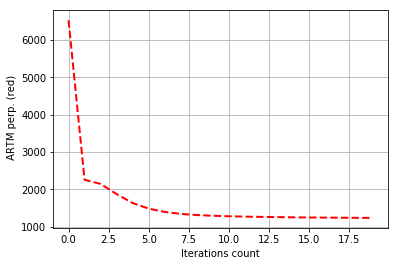

In [77]:
print_measures(model_artm)

Посмотрим на 20 тем

In [85]:
print_topics(model_artm, 20)

Topic: topic_1
['данные', 'запись', 'диск', 'данный', 'информация', 'хранение', 'хранилище', 'хранить', 'кеш', 'храниться']

Topic: topic_2
['атака', 'уязвимость', 'безопасность', 'защита', 'злоумышленник', 'компания', 'проблема', 'устройство', 'угроза', 'обнаруживать']

Topic: topic_3
['человек', 'жизнь', 'ваш', 'говорить', 'помогать', 'дело', 'часто', 'хороший', 'ребенок', 'исследование']

Topic: topic_4
['страна', 'город', 'китай', 'россия', 'регион', 'сша', 'государство', 'правительство', 'население', 'гражданин']

Topic: topic_5
['компьютер', 'битный', 'ассемблер', 'бит', 'инструкция', 'процессор', 'микросхема', 'архитектура', 'результат', 'калькулятор']

Topic: topic_6
['робот', 'дрон', 'полет', 'человек', 'мотор', 'аппарат', 'скорость', 'машина', 'дронов', 'крыло']

Topic: topic_7
['пост', 'пользователь', 'комментарий', 'ваш', 'иконка', 'текст', 'добавлять', 'роль', 'шрифт', 'навигация']

Topic: topic_8
['запрос', 'сервер', 'база', 'пользователь', 'процесс', 'ошибка', 'ответ', '

В целом получилось очень даже достойно.
Темы осмысленны, полноценны, практически лишены шума, разнообразны и преимущественно гомогенны.
Уже базовая модель, в моем видении, работает значительно лучше `gensim.LDA` и стремится по качеству к `NMF`.  
Интересны, например, темы, которых точно не было в `gensim.LDA`: географическая тема 4, связанная с деньгами тема 11 или связанная с дронами тема 6.  
Но есть и несколько сумбурные и малоосмысленные темы вроде 3 или 16. 

Добавим теперь sparse-регуляризатор на разреженность слов в темах и повторим эксперимент

In [131]:
%%time
model_artm2 = _artm(
    batch_vectorizer=batch_vectorizer,
    dictionary=dictionary,
    n_epochs=30,
    sparse_phi_tau=-0.2
)

Wall time: 41.6 s


Качество примерно аналогичное, только сошлась модель раньше

Sparsity Phi: 0.984 ARTM)
Sparsity Theta: 0.032 (ARTM)
Kernel contrast: 0.757 (ARTM)
Kernel purity: 0.858 (ARTM)
Perplexity: 1398.631 (ARTM)


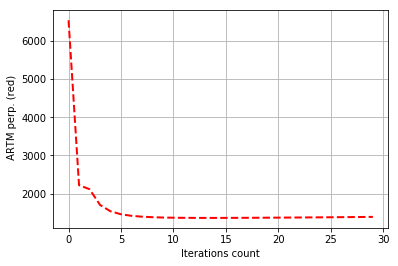

In [132]:
print_measures(model_artm2)

In [133]:
print_topics(model_artm2, 20)

Topic: topic_1
['данные', 'запись', 'диск', 'хранить', 'хранение', 'информация', 'данный', 'хранилище', 'храниться', 'сохранять']

Topic: topic_2
['безопасность', 'атака', 'письмо', 'защита', 'уязвимость', 'злоумышленник', 'угроза', 'рассылка', 'хакер', 'шифрование']

Topic: topic_3
['человек', 'жизнь', 'дело', 'хороший', 'помогать', 'находить', 'день', 'мысль', 'думать', 'сказать']

Topic: topic_4
['связь', 'номер', 'оператор', 'страна', 'регион', 'звонок', 'вызов', 'принимать', 'глобальный', 'оператор_связь']

Topic: topic_5
['инструкция', 'байт', 'бит', 'регистр', 'адрес', 'битный', 'компилятор', 'результат', 'ассемблер', 'кристалл']

Topic: topic_6
['устройство', 'камера', 'датчик', 'аккумулятор', 'прибор', 'корпус', 'аппарат', 'управление', 'батарея', 'производитель']

Topic: topic_7
['ваш', 'комментарий', 'пост', 'пользователь', 'хотеть', 'стандарт', 'давать', 'рекомендовать', 'предлагать', 'любой']

Topic: topic_8
['процесс', 'база', 'выполнять', 'случай', 'выполнение', 'происхо

Особенно темы не поменялись, но малые улучшения все же видны: например, упразднилась нелепая тема 16 и на ее место пришла вполне хорошая математическая тема.  

Посмотрим теперь отдельно на регуляризатор на разреженность тем

In [137]:
%%time
model_artm3 = _artm(
    batch_vectorizer=batch_vectorizer,
    dictionary=dictionary,
    n_epochs=15,
    sparse_theta_tau=-0.2,
    theta_tau_coef=0.75
)

Wall time: 20.5 s


Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.949 (ARTM)
Kernel contrast: 0.187 (ARTM)
Kernel purity: 0.129 (ARTM)
Perplexity: 1270.057 (ARTM)


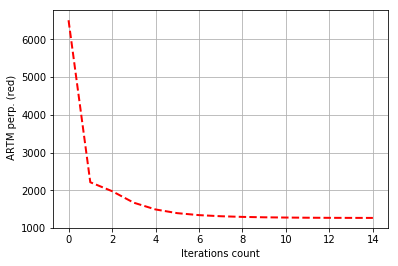

In [138]:
print_measures(model_artm3)

In [139]:
print_topics(model_artm3, 20)

Topic: topic_1
['данные', 'запись', 'диск', 'данный', 'хранилище', 'файл', 'хранение', 'информация', 'кеш', 'состояние']

Topic: topic_2
['атака', 'компания', 'уязвимость', 'устройство', 'проблема', 'данные', 'пользователь', 'биткоин', 'злоумышленник', 'защита']

Topic: topic_3
['человек', 'жизнь', 'ваш', 'говорить', 'книга', 'дело', 'понимать', 'знать', 'помогать', 'хороший']

Topic: topic_4
['город', 'страна', 'результат', 'государство', 'россия', 'проект', 'человек', 'сша', 'интернет', 'регион']

Topic: topic_5
['процессор', 'программа', 'чип', 'компания', 'компьютер', 'микросхема', 'битный', 'ассемблер', 'инструкция', 'архитектура']

Topic: topic_6
['робот', 'дрон', 'человек', 'машина', 'полет', 'мотор', 'скорость', 'аппарат', 'очень', 'видео']

Topic: topic_7
['пользователь', 'пост', 'иконка', 'добавлять', 'текст', 'роль', 'ваш', 'интерфейс', 'шрифт', 'контроллер']

Topic: topic_8
['запрос', 'сервер', 'пользователь', 'данные', 'процесс', 'ответ', 'ошибка', 'проблема', 'сервис', 'о

Вновь практически никаких изменений не наблюдается, а наполнение тем очень похоже на случай без sparse-регуляризаторов.

Теперь попробуем оба разреживающих регуляризатора одновременно

In [140]:
%%time
model_artm4 = _artm(
    batch_vectorizer=batch_vectorizer,
    dictionary=dictionary,
    n_epochs=30,
    sparse_phi_tau=-0.2,
    sparse_theta_tau=-0.2,
    theta_tau_coef=0.75
)

Wall time: 43.3 s


Sparsity Phi: 0.982 ARTM)
Sparsity Theta: 0.920 (ARTM)
Kernel contrast: 0.551 (ARTM)
Kernel purity: 0.620 (ARTM)
Perplexity: 1458.162 (ARTM)


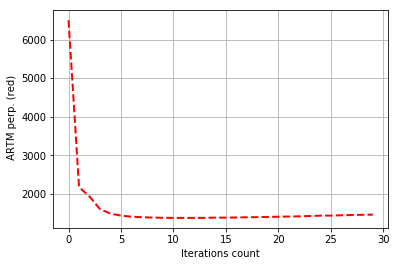

In [142]:
print_measures(model_artm4)

In [144]:
print_topics(model_artm4, 20)

Topic: topic_1
['данные', 'диск', 'запись', 'кеш', 'файл', 'чтение', 'ключ', 'хранение', 'данный', 'хранилище']

Topic: topic_2
['атака', 'письмо', 'уязвимость', 'компания', 'злоумышленник', 'рассылка', 'атаковать', 'защита', 'подписчик', 'уязвимый']

Topic: topic_3
['человек', 'хороший', 'проблема', 'ваш', 'находить', 'давать', 'хотя', 'именно', 'результат', 'любой']

Topic: topic_4
['карта', 'номер', 'участник', 'оператор', 'звонок', 'вызов', 'банк', 'оплата', 'перевод', 'набор']

Topic: topic_5
['регистр', 'инструкция', 'процессор', 'архитектура', 'программа', 'байт', 'компилятор', 'ассемблер', 'битный', 'адрес']

Topic: topic_6
['устройство', 'датчик', 'камера', 'аккумулятор', 'использоваться', 'управление', 'прибор', 'аппарат', 'производитель', 'использование']

Topic: topic_7
['контроллер', 'добавлять', 'пользователь', 'модель', 'роль', 'пост', 'функция', 'шаблон', 'модуль', 'изменять']

Topic: topic_8
['сервер', 'запрос', 'пользователь', 'проблема', 'данные', 'ошибка', 'случай',

Теперь видны некоторые изменения.  
Так, появилась совершенно новая тема 4, связанная с банковскими операциями, и тема 17 о строительстве (правда, с небольшим шумом).  
Дополнительно очень хорошо уточнилась тема 5 о CPU.  
Среди 3 тем особенно хотелось бы выделить 5, 13 и 15, очень точно описывающие ту или иную область CS в целом.

In [59]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(200)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.25, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(1, 200)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.15, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)])
                                    ]
                        )

# не забывайте менять количество топиков в регуляризаторах, они применяются только на тех темах, что заданы

In [60]:
# инициализурем модель словарем
model_artm.initialize(dictionary=dictionary, )

In [61]:
# добавляем метрики
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 

### Тренируем модель

Пройдемся несколько раз по коллекции, чтобы модель немного сошлась (если доков сильно больше то может быть достаточно и 1 прохода). Для сильно больших коллекций есть fit_online, который обновляется в процессе прохода по коллекции, про него можно почитать в документации.

In [64]:
model_artm.num_document_passes = 10
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.001 (ARTM)
Kernel contrast: 0.187 (ARTM)
Kernel purity: 0.140 (ARTM)
Perplexity: 1146.464 (ARTM)


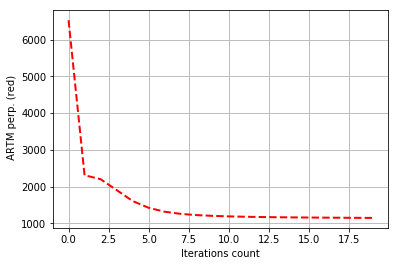

In [65]:
# посмотрим, что стало с моделью
# если график сильно падал на последних итерациях, то можно прогнать обучение ещё несколько раз 
# (не добавляя другие регуляризаторы)
print_measures(model_artm)

Добавим регуляризаторы разреженности тем и документов.

Их рекомендуется добавлять после того, как модель уже как-то сошлась. После добавления их рекомендуется постепенно уменьшать, чтобы усиливать разреживание. Их можно применять не ко всем темам, чтобы в каких-то темах собрались все стоп-слова.

Можно добавлять их вместе или по отдельности.

In [ ]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 200)],
                                                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 200)]))

In [ ]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

In [ ]:
# будем постепенно увеличивать значения этих регуляризаторов
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.5))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)
    

In [ ]:
# посмотрим на качество
print_measures(model_artm)

Перплексия должна снижаться. Если график выровнился и больше не меняется - модель сошлась. Обычно перплексия хорошей модели около 200-1000. На таком небольшом количестве данных возможно такого значения достичь не получится.

In [54]:
# посмотрим на темы
for topic_name in model_artm.topic_names[:50]:
    print(topic_name + ': ')
    try:
        for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('---------')
    
    except KeyError: # можно перекрутить параметры и некоторые темы окажутся пустыми
        continue

topic_0: 
данные
диск
кеш
механизм
состояние
использование
запись
являться
хранилище
изменение
---------
topic_1: 
весна
смартфон
биткоин
спектрометр
стилус
компания
хороший
очень
проблема
устройство
---------
topic_2: 
человек
курс
книга
лекция
слово
хороший
час
сказать
чувство
вопрос
---------
topic_3: 
результат
являться
подразделение
большой
теория
исследование
процесс
ес
проблема
решение
---------
topic_4: 
результат
задача
процесс
случай
хотя
говорить
общий
мало
хороший
большой
---------
topic_5: 
камера
аккумулятор
дрон
ток
датчик
мотор
батарея
напряжение
устройство
аппарат
---------
topic_6: 
пост
пользователь
ваш
хороший
любой
статья
использование
хотеть
давать
проблема
---------
topic_7: 
отчет
задача
база
ошибка
процесс
пользователь
запись
заказчик
данные
ответ
---------
topic_8: 
доклад
конференция
рассказывать
участник
тема
выступление
мероприятие
разработчик
презентация
спикер
---------
topic_9: 
глава
велосипед
книга
слово
говорить
компьютер
именно
хотя
программа
идея
--

## Домашнее задание

Основаная задача - **построить хорошую тематическую модель с интерпретируемыми топиками**.

1) сделайте нормализацию (если pymorphy2 работает долго используйте mystem или попробуйте установить быструю версию - `pip install pymorphy2[fast]`, можно использовать какой-то другой токенизатор) 

2) добавьте нграммы (в тетрадке есть закомменченая ячейка с Phrases); 

3) сохраните тексты .vw формате;

4) сделайте хороший словарь (отфильтруйте слишком частотные и редкие слова, попробуйте удалить стоп-слова, сохраните словарь и посмотрите на него, вдруг что-то плохое сразу будет заметно); 

5) постройте несколько ARTM моделей (переберите количество тем, поменяйте значения tau у регуляризаторов), если получаются плохие темы, поработайте дополнительно над предобработкой и словарем; 

6) для самой хорошей модели в отдельной ячейке напечатайте 3 хороших (на ваш вкус) темы

7) в другой ячейки нарисуйте график обучения этой модели 

8) в третьей ячейки опишите какие параметры (количество тем, регуляризаторы, их tau) вы использовали и как обучали (например, после скольки проходов добавили регуляризатор разрежнивания тем (Phi), добавляли ли разреженность документам (Theta) и когда, как повышали значения, сколько итерации модель продожала улучшаться (снижалась перплексия, росли другие метрики);

Сохраните тетрадку с экспериментами и положите её на гитхаб, ссылку на неё укажите в форме.

**Оцениваться будут главным образом пункты 6, 7 и 8. (3, 1, 4 баллов соответственно). Чтобы заработать остальные 2 балла, нужно хотя бы немного изменить мой код на промежуточных этапах (добавить что-то, указать другие параметры и т.д). **